In [ ]:
import RxInferClientOpenAPI
import h5py
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class RxInfer:
	def __init__(self, token: str = None):
		self.client = RxInferClientOpenAPI.ApiClient()
		if token:
			self.token = token
		else:
			self.token = RxInferClientOpenAPI.AuthenticationApi(self.client).generate_token().token
			print(f"A new token has been generated: {self.token}")
		self.client.default_headers['Authorization'] = f"Bearer {self.token}"

	def create_model(self, model_name: str, description: str = None):
		self.model_id = RxInferClientOpenAPI.ModelsApi(self.client).create_model({
			"model": model_name,
			"description": description
		}).model_id
		print(f"Model {model_name} has been created with id {self.model_id}")
		return self.model_id
	
	def infer(self, model_id: str = None, data: dict = None, timestamp: str = None, episode_name: str = "default"):
		selected_model_id = model_id if model_id else self.model_id
		if (data is not None)and (data.get("t") is not None)and (timestamp is None):
			timestamp = data.get("t")[0]
		response = RxInferClientOpenAPI.ModelsApi(self.client).run_inference(
			model_id=selected_model_id,
			infer_request={
				"data": data,
				"timestamp": timestamp,
				"episode_name": episode_name
			})
		return response
	
	def plan(self, model_id: str = None, data: dict = None, timestamp: str = None, episode_name: str = "default"):
		selected_model_id = model_id if model_id else self.model_id
		response = RxInferClientOpenAPI.ModelsApi(self.client).run_planning(
			model_id=selected_model_id,
			planning_request={
				"data": data,
				"timestamp": timestamp,
				"episode_name": episode_name
			})
		return response
	
	def act(self, model_id: str = None, data: dict = None, timestamp: str = None, episode_name: str = "default"):
		selected_model_id = model_id if model_id else self.model_id
		response = RxInferClientOpenAPI.ModelsApi(self.client).run_action(
			model_id=selected_model_id,
			action_request={
				"data": data,
				"timestamp": timestamp,
				"episode_name": episode_name
			})
		return response

In [3]:
f = h5py.File("data/simulation.jld2", "r")
time = f["t"][:].tolist()
positions = [f[ref][:].tolist() for ref in f["position"][:]]
velocities = [f[ref][:].tolist() for ref in f["velocity"][:]]
attitudes = [f[ref][:].tolist() for ref in f["attitude"][:]]
angular_velocities = [f[ref][:].tolist() for ref in f["angular_velocity"][:]]
wind_velocities = [f[ref][:].tolist() for ref in f["wind"][:]]
dt = float(f["dt"][...])

In [4]:
def extract_results(results):
    positions = [result["position_mean"] for result in results]
    velocities = [result["velocity_mean"] for result in results]
    attitudes = [result["attitude_mean"] for result in results]
    angular_velocities = [result["angular_velocity_mean"] for result in results]
    wind_velocities = [result["wind_mean"] for result in results]
    return positions, velocities, attitudes, angular_velocities, wind_velocities

In [37]:
def plot_positions(positions, inferred_positions):
    plt.plot(time, inferred_positions, label=[f"inferred {i} position" for i in ["x", "y", "z"]])
    plt.plot(time, positions, label=[f"true {i} position" for i in ["x", "y", "z"]], linestyle="dotted", color="black")
    plt.grid()
    plt.legend()
    plt.show()
    
def plot_normalized_velocities(velocities, wind_velocities, inferred_velocities, inferred_wind_velocities):
    plt.plot(time, np.array(inferred_velocities), label=[f"inferred {i} velocity" for i in ["x", "y", "z"]])
    plt.plot(time, np.array(velocities), label=[f"true {i} velocity" for i in ["x", "y", "z"]], linestyle="dotted", color="black")
    plt.grid()
    plt.legend()
    plt.show()
    
def plot_planned_path(inferred_position, plan_response, goal_position):
	ax = plt.figure().add_subplot(projection='3d')
	ax.scatter([inferred_position[0]], [inferred_position[1]], [inferred_position[2]], label="inferred position")
	ax.scatter([goal_position[0]], [goal_position[1]], [goal_position[2]], label="goal position")
	ax.plot(
		[x[0] for x in plan_response.results["planned_state"]],
		[x[1] for x in plan_response.results["planned_state"]],
		[x[2] for x in plan_response.results["planned_state"]],
		label="planned path",
		linestyle="dashed"
	)
	ax.legend()

In [6]:
client = RxInfer()

A new token has been generated: 109eb2a9-b9d1-450e-a9fe-a83329d33a80


In [7]:
client.create_model("Drone-v1", "Simplified drone model");

Model Drone-v1 has been created with id 06c62f06-6b89-4517-bf05-e320169a5501


In [8]:
infer_response = client.infer(
    data={
        "t": [time[0]],
        "y": [positions[0]],
        "control": [0, 0, 0, 0]
	}
)

In [9]:
inferred_state = infer_response.results["state_mean"]

In [17]:
plan_response = client.plan(
    data={
        "goal_position": [2, 1, 0.5],
	}
)

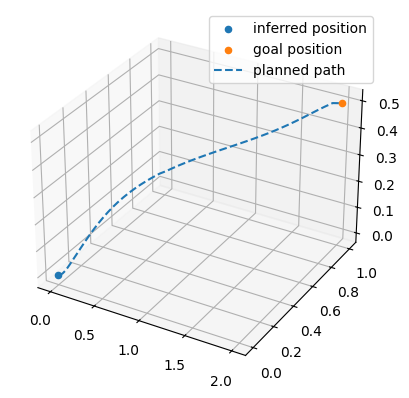

In [38]:
plot_planned_path(inferred_state, plan_response, [2, 1, 0.5])

In [7]:
break
inference_results = []
for t, y in zip(time, positions):
	response = client.infer(
		data={
			"t": [t],
			"y": [y]
		}
	)
	inference_results.append(response.results)

SyntaxError: 'break' outside loop (3460397650.py, line 1)

In [8]:
(
    inferred_positions, 
    inferred_velocities, 
    inferred_attitudes, 
    inferred_angular_velocities, 
    inferred_wind_velocities
) = extract_results(inference_results)

NameError: name 'inference_results' is not defined

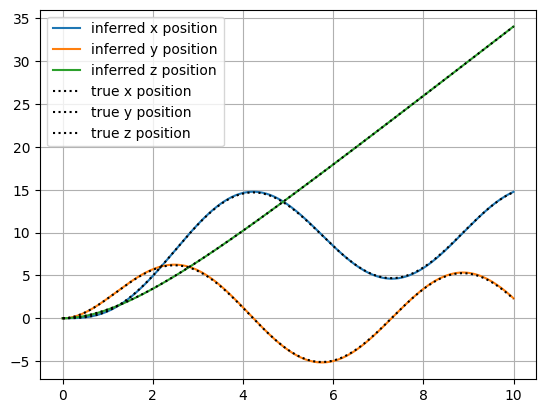

In [51]:
plot_positions(positions, inferred_positions)

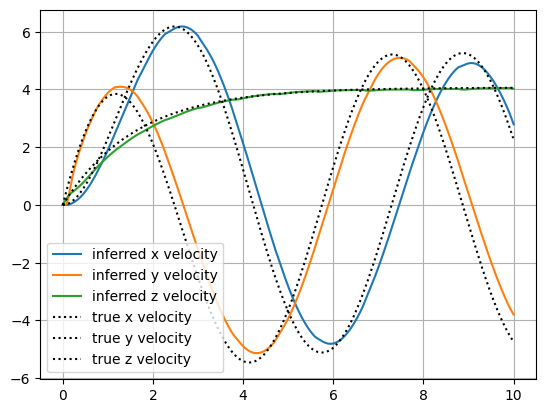

In [72]:
plot_normalized_velocities(velocities, wind_velocities, inferred_velocities, inferred_wind_velocities)